<a href="https://colab.research.google.com/github/franmazzaro/7506R-2C2023-GRUPO39/blob/main/7506R_TP1_GRUPO39_CHP3_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, BallTree, KDTree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree
import scipy.stats as st
import math as math
from sklearn.svm import SVC
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Preprocesamiento

In [35]:
# Importamos el dataset que trabajamos en el checkpoint 2 con las varibles categóricas como dummies
reservas = pd.read_csv('./content/sample_data/reservas_dummies.csv')

# Importamos el dataset de test con las variables categóricas como dummies
test = pd.read_csv('./content/sample_data/test_dummies.csv')

In [36]:
# Droppeamos el id para poder entrenar y predecir
ids_train = reservas["id"]
ids_test = test["id"]
reservas.drop(columns="id", inplace=True)
test.drop(columns="id", inplace=True)

# Ordenamos las columnas
reservas = reservas.reindex(sorted(reservas.columns), axis=1)
test = test.reindex(sorted(test.columns), axis=1)

# Imputamos datos faltantes
test['agent'] = test['agent'].fillna(-1)
test['company'] = test['company'].fillna(-1)

In [49]:
def mostrar_metricas(y_test, y_pred):
  #Cantidad de aciertos
  print('correctas: ', np.sum(y_test == y_pred))
  print('total: ', len(y_test))
  
  print(classification_report(y_test, y_pred))

  #Grafico la matriz de confusión
  tabla=confusion_matrix(y_test, y_pred)
  sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [79]:
def exportar_prediccion(ids_test, y_pred, filename):
  prediccion = pd.DataFrame({"id": ids_test, "is_canceled": y_pred})
  prediccion.to_csv('./content/sample_data/prediccion_'+filename+'.csv', index = False)

In [39]:
a = reservas.drop(['is_canceled'], axis=1)
b = reservas['is_canceled']

In [63]:
# Normalización Min-Max en los datos de entrenamiento
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(a)

# Balanceo de clases
class_0 = X_train_normalized[b == 0]
class_1 = X_train_normalized[b == 1]

# Balanceo de clases (sobremuestreo de la clase minoritaria)

# Selecciona los ejemplos de la clase mayoritaria (clase "0")
class_0 = X_train_normalized[b == 0]

# Selecciona los ejemplos de la clase minoritaria (clase "1")
class_1 = X_train_normalized[b == 1]

# Realiza sobremuestreo de la clase minoritaria (clase "1")
# - replace=True: Permite muestrear con reemplazo
# - n_samples=len(class_0): Genera tantas muestras de la clase "1" como ejemplos de la clase "0"
class_0_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)

# Combina los datos equilibrados en X_train_balanced y y_train_balanced
# - np.vstack: Apila verticalmente los arrays
# - np.hstack: Concatena horizontalmente los arrays
X_train_balanced = np.vstack((class_0, class_0_oversampled))
y_train_balanced = np.hstack((b[b == 0], np.ones(len(class_0))))

In [64]:
# Datos con normalización y balanceo
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(X_train_balanced, y_train_balanced, test_size=0.20, random_state=0)

test_bal  = scaler.transform(test)

# KNN classifier

## Con parámetros default

In [52]:
#Crear el modelo
KNN_Classifier = KNeighborsClassifier()

#Vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [53]:
#Entrenar el modelo
KNN_Classifier.fit(x_train_bal, y_train_bal)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test_bal)

### Métricas

correctas:  9607
total:  11718
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      5892
           1       0.81      0.83      0.82      5826

    accuracy                           0.82     11718
   macro avg       0.82      0.82      0.82     11718
weighted avg       0.82      0.82      0.82     11718



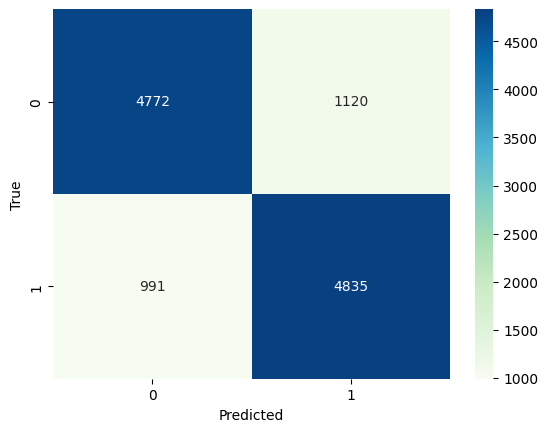

In [54]:
mostrar_metricas(y_test_bal, y_pred)

### Predicción sobre test

In [43]:
exportar_prediccion(ids_test, KNN_Classifier.predict(test_bal), "knn")

## Con parámetros optimizados

In [44]:
#Grilla de Parámetros
params_grid = {'n_neighbors':range(1,30),
               'weights':['distance','uniform'],
               'algorithm':['ball_tree', 'kd_tree', 'brute'],
               'metric':['euclidean','manhattan','chebyshev']
              }

#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=5)

rand.fit(x_train_bal, y_train_bal)
rand.cv_results_['mean_test_score']

array([0.82708513, 0.80248798, 0.80504437, 0.77285015, 0.82989315,
       0.80838266, 0.8108199 , 0.80706763, 0.83139714, 0.82344079])

In [45]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 19, 'metric': 'manhattan', 'algorithm': 'brute'}
0.8313971449816702


In [46]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test_bal)

### Métricas

correctas:  9854
total:  11718
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5892
           1       0.83      0.86      0.84      5826

    accuracy                           0.84     11718
   macro avg       0.84      0.84      0.84     11718
weighted avg       0.84      0.84      0.84     11718



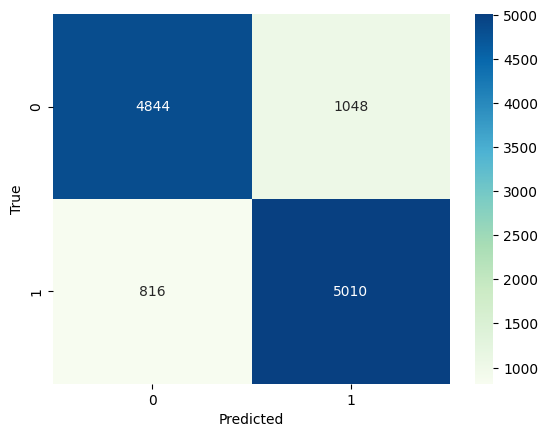

In [50]:
mostrar_metricas(y_test_bal, y_pred)

### Predicción sobre test

In [51]:
exportar_prediccion(ids_test, best_knn.predict(test_bal), "knn_opt")

# Support Vector Machine

## Con kernel lineal


In [56]:
from sklearn.model_selection import GridSearchCV
#Conjunto de parámetros que quiero usar
params_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']
    }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5)

#Clasificador
svm = SVC()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#RandomizedSearch CV
randomcv = GridSearchCV(estimator=svm,
                              param_grid = params_grid,
                              scoring=scorer_fn,
                              cv=5)

randomcv.fit(x_train_bal,y_train_bal)

print(randomcv.cv_results_['mean_test_score'])

[0.79185088 0.79581107 0.79662652]


In [57]:
#Mejores hiperparametros
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'C': 10, 'kernel': 'linear'}
0.7966265177909764


In [58]:
#Mejor estimador
best_svm_lin=randomcv.best_estimator_

#Predicción con mejor estimador
y_pred=best_svm_lin.predict(x_test_bal)

correctas:  9390
total:  11718
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      5892
           1       0.81      0.78      0.80      5826

    accuracy                           0.80     11718
   macro avg       0.80      0.80      0.80     11718
weighted avg       0.80      0.80      0.80     11718



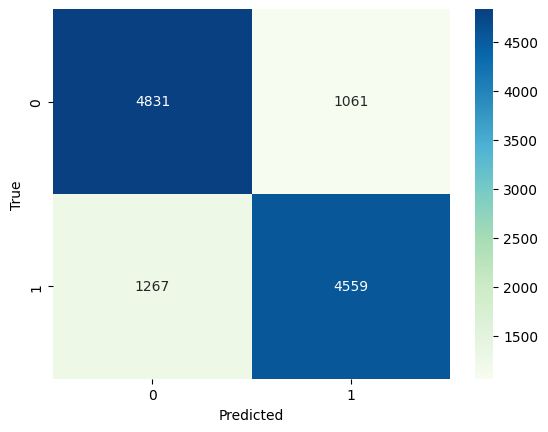

In [59]:
mostrar_metricas(y_test_bal, y_pred)

Vemos que el modelo SVM con kernel lineal tiene un mejor desempeño con C=10

## Con kernel polinómico

In [ ]:
#Conjunto de parámetros que quiero usar
params_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly'],
    'gamma': [0.1, 0.01, 0.001],
    'degree': [1, 2],
    'coef0': [0.0, 0.1, 0.5]
    }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5)

#Clasificador
svm = SVC()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#RandomizedSearch CV
randomcv = RandomizedSearchCV(estimator=svm,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=5,
                              random_state=1)
randomcv.fit(x_train_bal,y_train_bal)

print(randomcv.cv_results_['mean_test_score'])

[0.79177109 0.60141586 0.77513472 0.6733838  0.77519993]


In [ ]:
#Mejores hiperparametros
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'kernel': 'poly', 'gamma': 0.1, 'degree': 1, 'coef0': 0.5, 'C': 1}
0.7917710851752797


In [ ]:
#Mejor estimador
best_svm_poly=randomcv.best_estimator_

#Predicción con mejor estimador
y_pred=best_svm_poly.predict(x_test_bal)

0.8003925584570746

### Métricas

correctas:  9379
total:  11718
Accuracy score:  0.8003925584570746


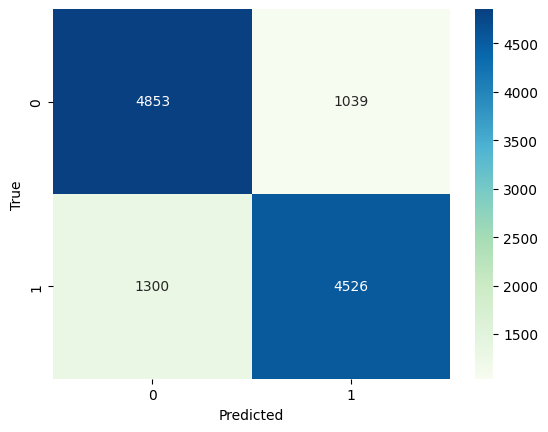

In [ ]:
mostrar_metricas(y_test_bal, y_pred)

### Predicción sobre test

In [ ]:
exportar_prediccion(ids_test, best_svm_poly.predict(test_bal), "svm_opt")

## Con kernel radial

In [60]:
from sklearn.metrics import f1_score, make_scorer

#Conjunto de parámetros que quiero usar
params_grid =  {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': [0.1, 0.01],
    'probability': [False]
                }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=10)

#Clasificador
svm = SVC()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#RandomizedSearch CV
randomcv = RandomizedSearchCV(estimator=svm,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=5)
randomcv.fit(x_train_bal,y_train_bal)

print(randomcv.cv_results_['mean_test_score'])

[0.81368532 0.79673182 0.83034667 0.80630183 0.7336898 ]


In [61]:
#Mejores hiperparametros
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'probability': False, 'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
0.8303466744587134


In [65]:
#Mejor estimador
best_svm_rad=randomcv.best_estimator_

#Predicción con mejor estimador
y_pred=best_svm_rad.predict(x_test_bal)

### Métricas

correctas:  9863
total:  11794
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83      5798
         1.0       0.84      0.84      0.84      5996

    accuracy                           0.84     11794
   macro avg       0.84      0.84      0.84     11794
weighted avg       0.84      0.84      0.84     11794



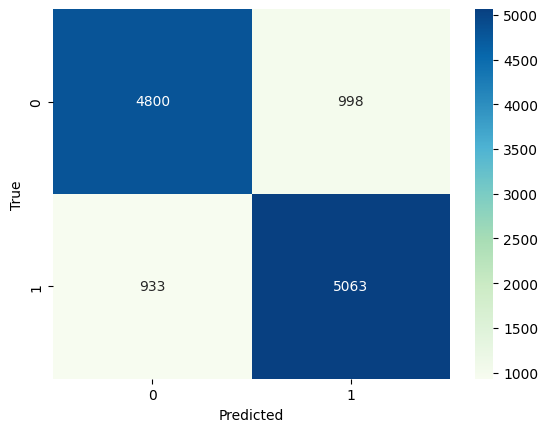

In [66]:
mostrar_metricas(y_test_bal, y_pred)

### Predicción sobre test

In [80]:
exportar_prediccion(ids_test, best_svm_rad.predict(test_bal), "svm_rad_opt")

# Random Forest

## Con parametros default

In [67]:
random_forest = RandomForestClassifier()

random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [68]:
#Entrenar el modelo
random_forest.fit(x_train_bal, y_train_bal)

#Predicción sobre test
y_pred = random_forest.predict(x_test_bal)

### Métricas

correctas:  10697
total:  11794
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90      5798
         1.0       0.90      0.92      0.91      5996

    accuracy                           0.91     11794
   macro avg       0.91      0.91      0.91     11794
weighted avg       0.91      0.91      0.91     11794



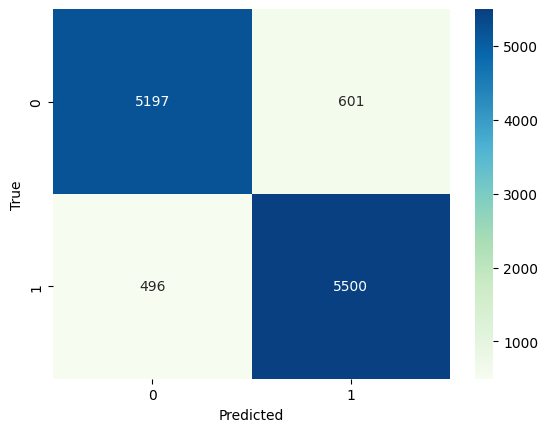

In [69]:
mostrar_metricas(y_test_bal, y_pred)

### Predicción sobre test

In [81]:
exportar_prediccion(ids_test, random_forest.predict(test_bal), "random_forest")

## Con Parametros Optimizados

In [70]:
param_grid = {
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.1, 0.2],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 50, 100, 200],
    'random_state': [42],
}

rf_classifier = RandomForestClassifier()

#Random Search con 5 Folds y 10 iteraciones
rand_rf = RandomizedSearchCV(rf_classifier, param_grid, cv=5, scoring='f1', n_iter=10, random_state=5)

rand_rf.fit(x_train_bal, y_train_bal)
rand_rf.cv_results_['mean_test_score']

array([0.2659308 , 0.47995415, 0.89334693, 0.47995415, 0.        ,
       0.26590242, 0.51312753, 0.8354557 , 0.84264499, 0.        ])

In [71]:
#Mejores hiperparametros
print(rand_rf.best_params_)
#Mejor métrica
print(rand_rf.best_score_)

{'random_state': 42, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0.0, 'bootstrap': False}
0.8933469341532841


In [72]:
#Mejor estimador
best_random_forest=rand_rf.best_estimator_

y_pred = best_random_forest.predict(x_test_bal)

### Métricas

correctas:  10611
total:  11794
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      5798
         1.0       0.90      0.90      0.90      5996

    accuracy                           0.90     11794
   macro avg       0.90      0.90      0.90     11794
weighted avg       0.90      0.90      0.90     11794



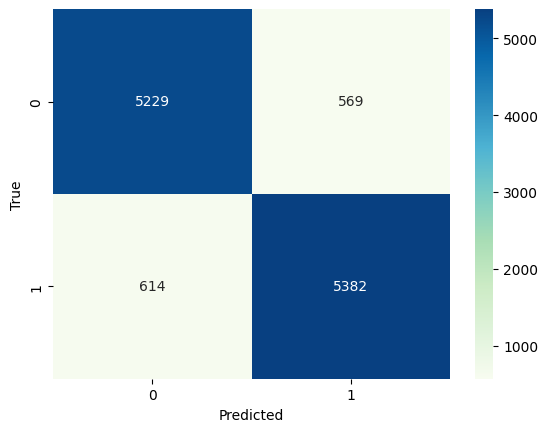

In [73]:
mostrar_metricas(y_test_bal, y_pred)

In [82]:
exportar_prediccion(ids_test, best_random_forest.predict(test_bal), "random_forest_optimizado")

## Graficamos el arbol

In [ ]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(best_random_forest.estimators_[48],
                                 feature_names=a.columns.to_list(),
                                 filled=True,
                                 rounded=True,
                                 class_names=['0','1'])
plt.show(tree_plot_completo)

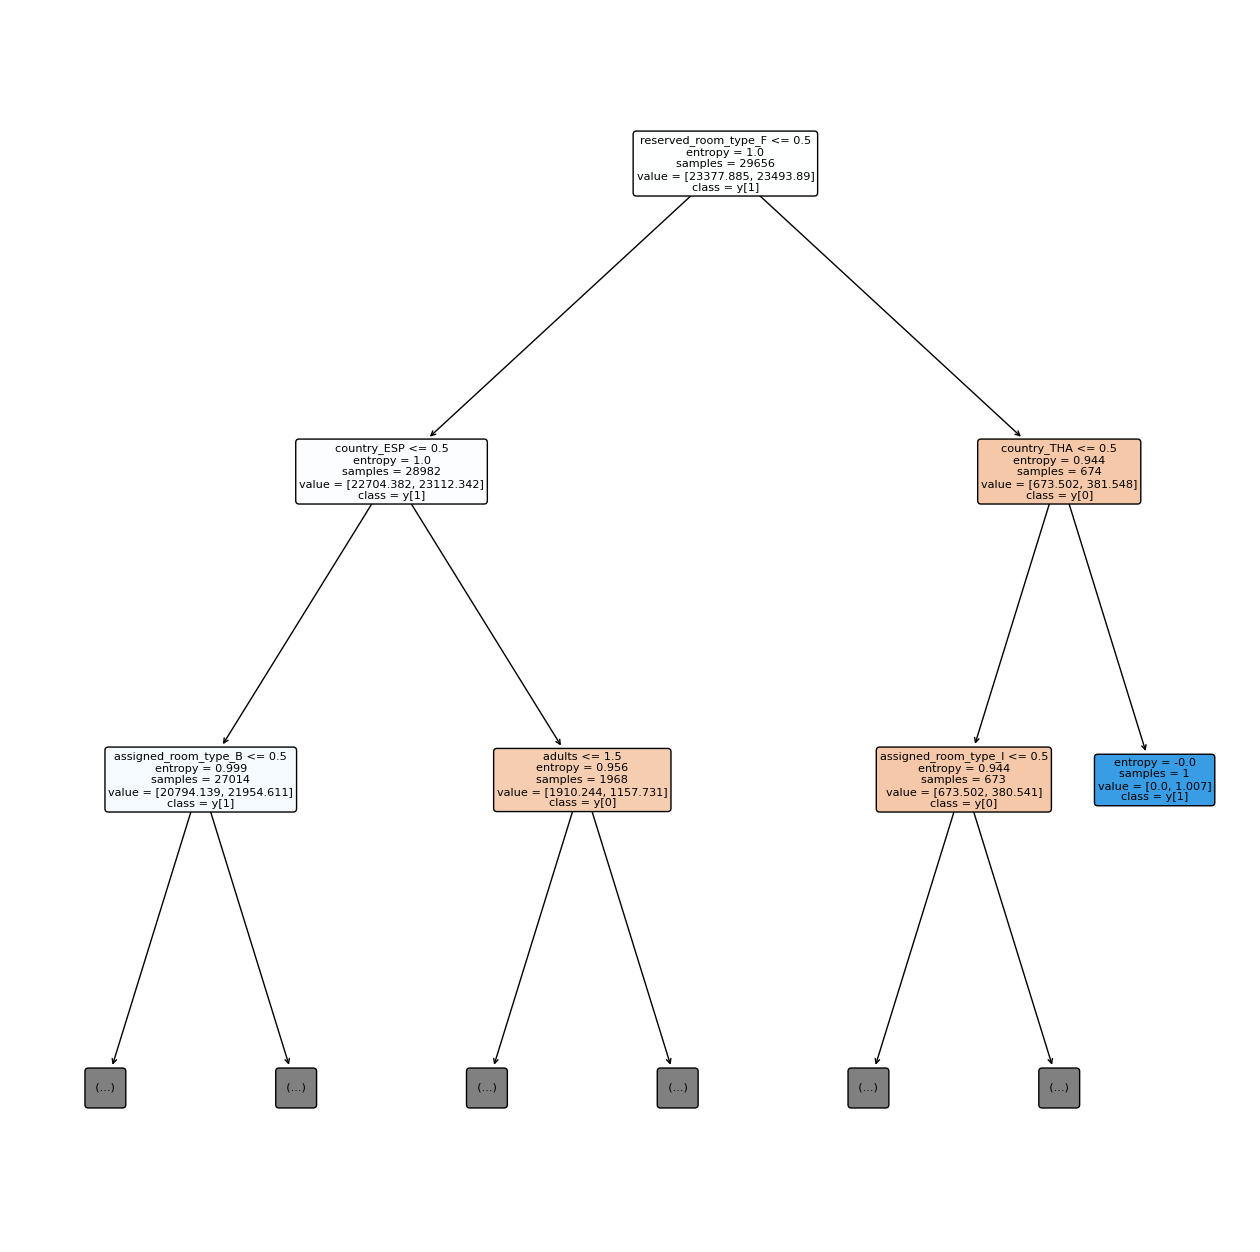

In [ ]:
plt.figure(figsize=(16,16))

tree_plot=tree.plot_tree(best_random_forest.estimators_[48],
                         max_depth=2,
                         feature_names=a.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

# XG Boost

## Con parametros Default

In [74]:
xg_boost_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xg_boost_model.fit(x_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

correctas:  10179
total:  11794
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      5798
         1.0       0.86      0.87      0.87      5996

    accuracy                           0.86     11794
   macro avg       0.86      0.86      0.86     11794
weighted avg       0.86      0.86      0.86     11794



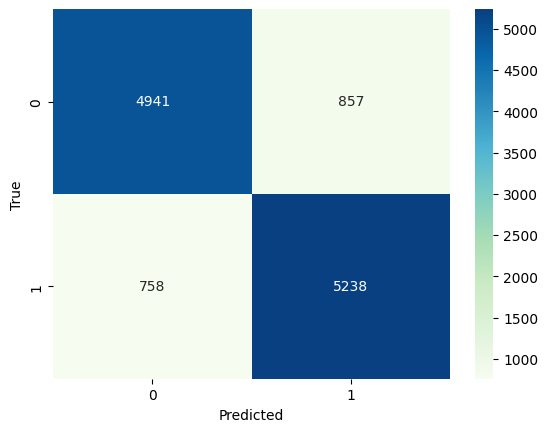

In [75]:
#Evaluo en el set de test
y_pred = xg_boost_model.predict(x_test_bal)

mostrar_metricas(y_test_bal, y_pred)

## Optimizo hiperparametros

In [76]:
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Tasa de aprendizaje
    'max_depth': [3, 4, 5, 6, 7, 8, 9],  # Profundidad máxima del árbol
    'min_child_weight': [1, 2, 3, 4],  # Mínimo peso de un niño (para evitar divisiones adicionales)
    'subsample': [0.8, 0.9, 1.0],  # Proporción de muestras utilizadas para entrenar árboles
    'colsample_bytree': [0.8, 0.9, 1.0],  # Proporción de características utilizadas para entrenar árboles
    'gamma': [0, 0.1, 0.2, 0.3],  # Parámetro de regularización para la poda
    'n_estimators': [100, 200, 300],  # Número de árboles (estimadores) en el bosque
}

# Inicializa el clasificador XGBoost
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=0)

# Realiza la búsqueda de hiperparámetros utilizando RandomizedSearchCV
n_iter = 10  # Número de combinaciones aleatorias a probar
xgb_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist, n_iter=n_iter, scoring='f1', cv=5, random_state=0)

# Ajusta el modelo a los datos de entrenamiento
xgb_search.fit(x_train_bal, y_train_bal)

xgb_search.best_params_

{'subsample': 0.8,
 'n_estimators': 200,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'colsample_bytree': 0.9}

correctas:  10450
total:  11794
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88      5798
         1.0       0.88      0.90      0.89      5996

    accuracy                           0.89     11794
   macro avg       0.89      0.89      0.89     11794
weighted avg       0.89      0.89      0.89     11794



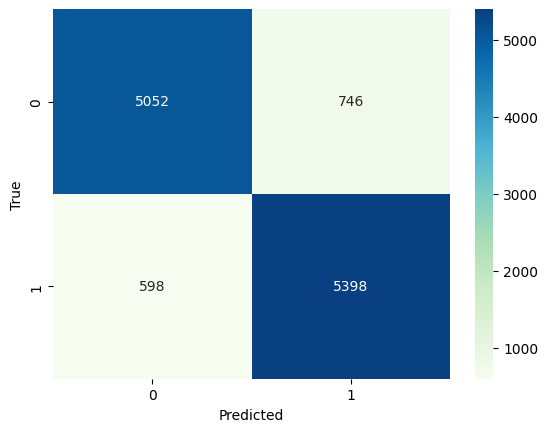

In [77]:
#Mejor modelo
best_xgb_classifier = xgb_search.best_estimator_ 

#Evaluo en el set de test
y_pred = best_xgb_classifier.predict(x_test_bal)

mostrar_metricas(y_test_bal, y_pred)

# Ensambles híbridos

## Stacking

In [86]:
#Modelos Base
base_models = [('random_forest', best_random_forest), 
               ('svm', best_svm_rad),
               ('xgboost', best_xgb_classifier)]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensamble Stacking
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

In [87]:
#Funcion para plotear accuracy
def plot_results(model_scores, name):

    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )

    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [88]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_val_score(stacking_model, x_train_bal, y_train_bal, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')

#Guarda los scores de cada modelo
model_scores = defaultdict()
model_scores['random_forest'] = rand_rf.cv_results_['mean_test_score']
model_scores['svm'] = randomcv.cv_results_['mean_test_score']
model_scores['xgboost'] = xgb_search.cv_results_['mean_test_score']
model_scores['stacking'] = scores

# Grafico de la performance
plot_results(model_scores, name='stacking_model_cv')

c:\Users\aruca\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\aruca\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

correctas:  10616
total:  11794
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      5798
         1.0       0.91      0.90      0.90      5996

    accuracy                           0.90     11794
   macro avg       0.90      0.90      0.90     11794
weighted avg       0.90      0.90      0.90     11794



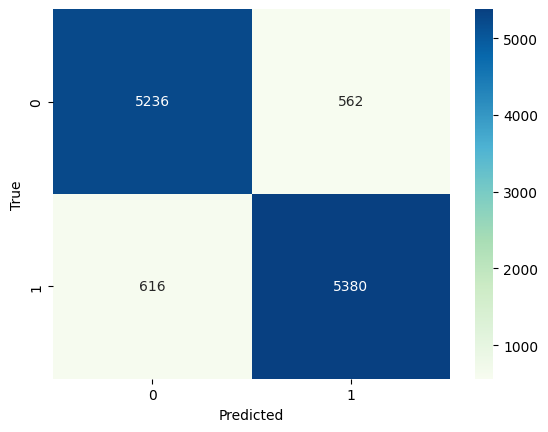

In [92]:
#Evaluo en conjunto de test
stacking_model.fit(x_train_bal,y_train_bal)
y_pred = stacking_model.predict(x_test_bal)
mostrar_metricas(y_test_bal, y_pred)

In [93]:
exportar_prediccion(ids_test, stacking_model.predict(test_bal), "stacking")

## Voting

correctas:  10507
total:  11794
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      5798
         1.0       0.89      0.90      0.89      5996

    accuracy                           0.89     11794
   macro avg       0.89      0.89      0.89     11794
weighted avg       0.89      0.89      0.89     11794



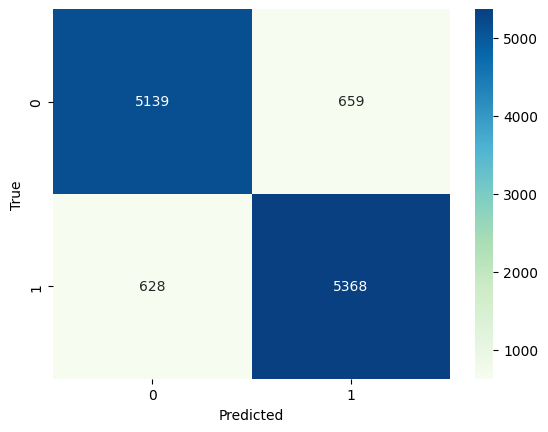

In [95]:
vot_clf = VotingClassifier(estimators = [('svm', best_svm_rad), ('xgboost', best_xgb_classifier), ('random_forest', best_random_forest)], voting = 'hard')

#Entreno el ensemble
vot_clf.fit(x_train_bal, y_train_bal)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test_bal)

mostrar_metricas(y_test_bal, pred)

In [96]:
exportar_prediccion(ids_test, vot_clf.predict(test_bal), "voting")